In [1]:
import pandas as pd
import math

Read original file

In [2]:
# Replace 'your_file.csv' with the path to your CSV file
file_path = './datathon_2024_dataset_corrected.csv'


# Read the CSV file into a pandas DataFrame
original_df = pd.read_csv(file_path)

# Only keep home_team or away_team equals HOU
astro_df = original_df.loc[(original_df['home_team'] == 'HOU') | (original_df['away_team'] == 'HOU')]

print(astro_df.head())

    Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
19          19   20000404       PIT       HOU        False           2   
32          32   20000405       PIT       HOU        False           2   
46          46   20000406       PIT       HOU         True          10   
57          57   20000407       HOU       PHI        False           1   
72          72   20000408       HOU       PHI         True           8   

    away_score  venue            venue_name        city  ... away_hbp  \
19           5  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
32          11  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
46           1  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
57           4  HOU03      Minute Maid Park     Houston  ...        0   
72           5  HOU03      Minute Maid Park     Houston  ...        1   

    home_pa  home_1b  home_2b  home_3b  home_hr  home_fo  home_so  home_bb  \
19       36        5        0        0

Read location file

In [3]:
location_file_path = './cities_coordinates.xlsx'
location_df = pd.read_excel(location_file_path)
print(location_df.head())

         city  latitude  longitude
0     Atlanta   33.7490   -84.3880
1  Cincinnati   39.1031   -84.5120
2       Miami   25.7617   -80.1918
3    Montreal   45.5017   -73.5673
4    New York   40.7128   -74.0060


Function to calculate the distance with latitudes and longitudes.

In [4]:
# Calculate the distance between two points.

def haversine(lat1, lon1, lat2, lon2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine公式
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # 地球半径（单位：公里）
    radius = 6371.0

    # 计算距离
    distance = radius * c

    return distance

# 示例：两个地点的经纬度
lat1, lon1 = 37.7749, -122.4194  # 地点1（例如，旧金山）
lat2, lon2 = 34.0522, -118.2437  # 地点2（例如，洛杉矶）

# 计算距离
result = haversine(lat1, lon1, lat2, lon2)
print(f"distance is：{result:.2f} ")


distance is：559.12 


Delete outlier cities.

In [5]:
#print out all city names

# Delelete all rows with city "Tokyo", "London", "Sydney",  "San Juan", "Monterrey"
astro_df = astro_df[astro_df['city'] != 'Tokyo']
astro_df = astro_df[astro_df['city'] != 'London']
astro_df = astro_df[astro_df['city'] != 'Sydney']
astro_df = astro_df[astro_df['city'] != 'San Juan']
astro_df = astro_df[astro_df['city'] != 'Monterrey']

# print(original_df['city'].unique())

# Count the number of unique city
# print(original_df['city'].nunique())



Add location to original file.

In [6]:
import pandas as pd

# Assuming both venue_name columns are of the same data type


# Merge the two DataFrames based on 'venue_name'
merged_df = pd.merge(astro_df, location_df, on='city', how='inner')

# 'inner' will keep only the rows where venue_name exists in both tables

# Display the merged DataFrame

# Sort merged_df by game_date
merged_df = merged_df.sort_values(by='game_date')
print(merged_df.head(20))



      Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
0             19   20000404       PIT       HOU        False           2   
1             32   20000405       PIT       HOU        False           2   
2             46   20000406       PIT       HOU         True          10   
114           57   20000407       HOU       PHI        False           1   
115           72   20000408       HOU       PHI         True           8   
116           87   20000409       HOU       PHI         True           2   
117           99   20000410       HOU       SLN        False           7   
118          107   20000411       HOU       SLN        False           6   
119          119   20000412       HOU       SLN        False           7   
1999         150   20000414       SDN       HOU        False           4   
2000         163   20000415       SDN       HOU        False           5   
2001         179   20000416       SDN       HOU         True          13   
2055        

Calculate distance from last game.

In [7]:
# Add a column distance to the merged_df. Calculate the distance between the city in this row and the city in last row.
# If the city in this row is the first city, then the distance is 0.
# Use the function haversine() to calculate the distance.
merged_df['distance'] = 0
for i in range(1, len(merged_df)):
    merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merged_df['latitude'].iloc[i], merged_df['longitude'].iloc[i])



/var/folders/4h/m7zq6dq13nvdg2z667851n9h0000gn/T/ipykernel_27705/3300626854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merged_df['latitude'].iloc[i], merged_df['longitude'].iloc[i])


In [8]:
# change game_date to datetime
merged_df['game_date'] = pd.to_datetime(merged_df['game_date'], format='%Y%m%d')

In [9]:
# Add a column BABIP to the merged_df. Calculate the BABIP for each row.
# BABIP = (home_1b + home_2b + home_3b - home_hr) / (home_pa - home_bb  - home_hbp - home_hr - home_so)
# Iterate through rows, if HOU is home_team, extract all home_ data, if HOU is away_team, extract all away_ data

merged_df['BABIP'] = 0

for i in range(0, len(merged_df)):
    if merged_df['home_team'].iloc[i] == 'HOU':
        merged_df['BABIP'].iloc[i] = (merged_df['home_1b'].iloc[i] + merged_df['home_2b'].iloc[i] + merged_df['home_3b'].iloc[i] - merged_df['home_hr'].iloc[i]) / (merged_df['home_pa'].iloc[i] - merged_df['home_bb'].iloc[i] - merged_df['home_hbp'].iloc[i] - merged_df['home_hr'].iloc[i] - merged_df['home_so'].iloc[i])
    else:
        merged_df['BABIP'].iloc[i] = (merged_df['away_1b'].iloc[i] + merged_df['away_2b'].iloc[i] + merged_df['away_3b'].iloc[i] - merged_df['away_hr'].iloc[i]) / (merged_df['away_pa'].iloc[i] - merged_df['away_bb'].iloc[i] - merged_df['away_hbp'].iloc[i] - merged_df['away_hr'].iloc[i] - merged_df['away_so'].iloc[i])

print(merged_df[['game_date', 'BABIP']])

/var/folders/4h/m7zq6dq13nvdg2z667851n9h0000gn/T/ipykernel_27705/2674775903.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['BABIP'].iloc[i] = (merged_df['away_1b'].iloc[i] + merged_df['away_2b'].iloc[i] + merged_df['away_3b'].iloc[i] - merged_df['away_hr'].iloc[i]) / (merged_df['away_pa'].iloc[i] - merged_df['away_bb'].iloc[i] - merged_df['away_hbp'].iloc[i] - merged_df['away_hr'].iloc[i] - merged_df['away_so'].iloc[i])


      game_date     BABIP
0    2000-04-04  0.125000
1    2000-04-05  0.347826
2    2000-04-06  0.100000
114  2000-04-07  0.125000
115  2000-04-08  0.250000
...         ...       ...
3536 2023-09-26  0.333333
3537 2023-09-27  0.258065
2570 2023-09-29  0.347826
2571 2023-09-30  0.260870
2572 2023-10-01  0.192308

[3784 rows x 2 columns]


In [10]:
# Caculate the average BABIP of each specific time period.

import pandas as pd

def calculate_average_BABIP(df):
    # Create a helper column to identify blocks
    df['block'] = (df['distance'] != 0).cumsum()

    # Calculating average score for each block
    avg_scores = df.groupby('block')['BABIP'].mean()

    # Mapping the average scores back to the original dataframe
    df['BABIP_average'] = df['block'].map(avg_scores)

    # Optionally, remove the helper column if it's no longer needed
    df.drop('block', axis=1, inplace=True)

    return df


# Apply the function to your dataframe
merged_df = calculate_average_BABIP(merged_df)

# Display the first few rows of the updated dataframe
print(merged_df[['distance', 'BABIP', 'BABIP_average']].head(20))

# Optionally, save the modified dataframe back to a CSV
# df.to_csv('modified_file.csv', index=False)


         distance     BABIP  BABIP_average
0        0.000000  0.125000       0.190942
1        0.000000  0.347826       0.190942
2        0.000000  0.100000       0.190942
114   1829.889838  0.125000       0.143778
115      0.000000  0.250000       0.143778
116      0.000000  0.217391       0.143778
117      0.000000 -0.047619       0.143778
118      0.000000  0.160000       0.143778
119      0.000000  0.157895       0.143778
1999  2093.853720  0.166667       0.224786
2000     0.000000  0.200000       0.224786
2001     0.000000  0.307692       0.224786
2055   179.410425  0.150000       0.259211
2056     0.000000  0.368421       0.259211
120   2206.264028  0.181818       0.195018
121      0.000000  0.100000       0.195018
122      0.000000  0.160000       0.195018
123      0.000000  0.451613       0.195018
124      0.000000  0.161290       0.195018
125      0.000000  0.115385       0.195018


In [11]:
# Delete all rows with distance equals zero
merged_df = merged_df[merged_df['distance'] != 0]
print(merged_df[["distance",'BABIP_average']].head(50))



         distance  BABIP_average
114   1829.889838       0.143778
1999  2093.853720       0.224786
2055   179.410425       0.259211
120   2206.264028       0.195018
2112  1618.872293       0.198278
2230   131.055603       0.205000
2057  2803.971507       0.215873
126   2206.264028       0.196517
2116  1618.872293       0.227273
2379  1172.349177       0.190760
2117  1172.349177       0.234856
133   1618.872293       0.178715
2397  1413.644844       0.343701
139   1413.644844       0.243118
2060  2206.264028       0.100000
2002   179.410425       0.251804
2400  1340.249516       0.222203
2455  1524.503301       0.242853
145   2643.045853       0.284293
2506  1632.166882       0.295944
2573  2043.754052       0.186250
151   1094.099848       0.206599
2681  1779.654964       0.280920
2720   145.133104       0.233889
157   1793.140904       0.224670
2759  1436.875034       0.285538
2861   595.451920       0.301641
2908   975.883024       0.172540
162   1556.794499       0.282896
2957  2156

In [12]:
# calculating the average point value of each specific time period (cities)

# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['HOU_score'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'HOU_score'] = row['home_score']
    else:
        merged_df.loc[index, 'HOU_score'] = row['away_score']



/var/folders/4h/m7zq6dq13nvdg2z667851n9h0000gn/T/ipykernel_27705/569813256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['HOU_score'] = 0


In [13]:
# Delete all rows with distance equals zero
merged_df = merged_df[merged_df['distance'] != 0]
print(merged_df[["distance",'HOU_score']].head(50))



         distance  HOU_score
114   1829.889838          1
1999  2093.853720         10
2055   179.410425          3
120   2206.264028          2
2112  1618.872293          7
2230   131.055603          1
2057  2803.971507          2
126   2206.264028          1
2116  1618.872293          5
2379  1172.349177          2
2117  1172.349177          9
133   1618.872293         10
2397  1413.644844          7
139   1413.644844          4
2060  2206.264028          2
2002   179.410425          7
2400  1340.249516          6
2455  1524.503301          4
145   2643.045853          6
2506  1632.166882          1
2573  2043.754052          4
151   1094.099848          4
2681  1779.654964          2
2720   145.133104          5
157   1793.140904          0
2759  1436.875034          7
2861   595.451920          2
2908   975.883024          4
162   1556.794499          7
2957  2156.270867          7
169   2156.270867         16
2382  2582.330426          3
3003   533.688483          2
178   2281.344

In [14]:
# calculating the average point of the HOU_score just received

import pandas as pd

def calculate_hou_avg_point(df):
    # Create a helper column to identify blocks
    df['block'] = (df['distance'] != 0).cumsum()

    # Calculating average score for each block
    avg_scores = df.groupby('block')['HOU_score'].mean()

    # Mapping the average scores back to the original dataframe
    df['HOU_AvgPoint'] = df['block'].map(avg_scores)

    # Optionally, remove the helper column if it's no longer needed
    df.drop('block', axis=1, inplace=True)

    return df


# Apply the function to your dataframe
merged_df = calculate_hou_avg_point(merged_df)

# Display the first few rows of the updated dataframe
print(merged_df[['distance', 'HOU_score', 'HOU_AvgPoint']].head(20))

# Optionally, save the modified dataframe back to a CSV
# df.to_csv('modified_file.csv', index=False)


         distance  HOU_score  HOU_AvgPoint
114   1829.889838          1           1.0
1999  2093.853720         10          10.0
2055   179.410425          3           3.0
120   2206.264028          2           2.0
2112  1618.872293          7           7.0
2230   131.055603          1           1.0
2057  2803.971507          2           2.0
126   2206.264028          1           1.0
2116  1618.872293          5           5.0
2379  1172.349177          2           2.0
2117  1172.349177          9           9.0
133   1618.872293         10          10.0
2397  1413.644844          7           7.0
139   1413.644844          4           4.0
2060  2206.264028          2           2.0
2002   179.410425          7           7.0
2400  1340.249516          6           6.0
2455  1524.503301          4           4.0
145   2643.045853          6           6.0
2506  1632.166882          1           1.0


In [15]:
# output a csv file
merged_df.to_csv('travel_analysis_astro.csv', index=False)

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = './travel_analysis_astro.csv'
data = pd.read_csv(file_path)

# Create a 'score_diff' column that reflects the margin of victory or defeat for the Houston Astros
data['score_diff'] = data.apply(lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'HOU' else row['away_score'] - row['home_score'], axis=1)
data['home_run'] = data.apply(lambda row: row['home_hr'] if row['home_team'] == 'HOU' else row['away_hr'], axis=1)
data['home_1b'] = data.apply(lambda row: row['home_1b'] if row['home_team'] == 'HOU' else row['away_1b'], axis=1)
data['home_2b'] = data.apply(lambda row: row['home_2b'] if row['home_team'] == 'HOU' else row['away_2b'], axis=1)
data['home_3b'] = data.apply(lambda row: row['home_3b'] if row['home_team'] == 'HOU' else row['away_3b'], axis=1)

# Fill missing values with zeros
data = data.fillna(0)

# Select features and the target variable
features = ['distance']
X = data[features]
y = data['HOU_AvgPoint']


# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Model coefficients
coefficients = model.coef_

# Output the RMSE and coefficients
print(f'RMSE: {rmse:.2f}')
print(f'Coefficients: {coefficients}')


RMSE: 3.26
Coefficients: [-0.07916624]


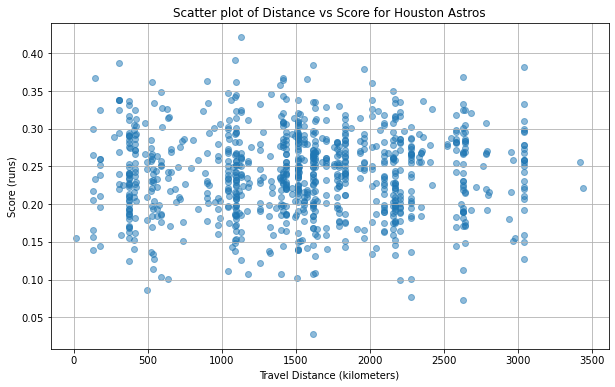

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting scatter points of 'distance' vs. 'score'
plt.figure(figsize=(10, 6))
plt.scatter(data['distance'], data['BABIP_average'], alpha=0.5)
plt.title('Scatter plot of Distance vs Score for Houston Astros')
plt.xlabel('Travel Distance (kilometers)')
plt.ylabel('Score (runs)')
plt.grid(True)
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = './travel_analysis_astro.csv'
data = pd.read_csv(file_path)

# Create a 'score_diff' column that reflects the margin of victory or defeat for the Houston Astros
data['score_diff'] = data.apply(lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'HOU' else row['away_score'] - row['home_score'], axis=1)
data['home_run'] = data.apply(lambda row: row['home_hr'] if row['home_team'] == 'HOU' else row['away_hr'], axis=1)
data['home_1b'] = data.apply(lambda row: row['home_1b'] if row['home_team'] == 'HOU' else row['away_1b'], axis=1)
data['home_2b'] = data.apply(lambda row: row['home_2b'] if row['home_team'] == 'HOU' else row['away_2b'], axis=1)
data['home_3b'] = data.apply(lambda row: row['home_3b'] if row['home_team'] == 'HOU' else row['away_3b'], axis=1)

# Fill missing values with zeros
data = data.fillna(0)

# Select features and the target variable
features = ['distance']
X = data[features]
y = data['BABIP_average']


# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Model coefficients
coefficients = model.coef_

# Output the RMSE and coefficients
print(f'RMSE: {rmse:.2f}')
print(f'Coefficients: {coefficients}')


RMSE: 0.05
Coefficients: [0.0006894]


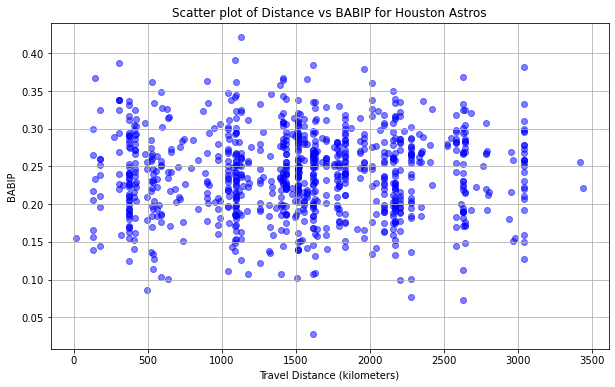

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting scatter points of 'distance' vs. 'BABIP'
plt.figure(figsize=(10, 6))
plt.scatter(X['distance'], y, alpha=0.5, color='blue')
plt.title('Scatter plot of Distance vs BABIP for Houston Astros')
plt.xlabel('Travel Distance (kilometers)')
plt.ylabel('BABIP')
plt.grid(True)
plt.show()